In [7]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.stats import binned_statistic_2d, binned_statistic
from numba import njit
import h5py as h5

from joblib import Parallel, delayed
import lowda
from lowda import get_time
import importlib

In [2]:
importlib.reload(lowda)

<module 'lowda' from '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/TNG/note/lowda.py'>

In [3]:
import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

zoombase = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/TNG/runs/gr187/output/'

In [4]:
GFM_SOLAR_METALLICITY = 0.0127

GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_HELIUM  =  (1.-GFM_SOLAR_ABUNDANCE_HYDROGEN -GFM_SOLAR_METALLICITY)
GFM_SOLAR_ABUNDANCE_CARBON  =  0.0024
GFM_SOLAR_ABUNDANCE_NITROGEN =  0.0007
GFM_SOLAR_ABUNDANCE_OXYGEN  =  0.0057
GFM_SOLAR_ABUNDANCE_NEON    =  0.0012
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_SILICON =  0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013
GFM_SOLAR_ABUNDANCE_OTHER  =   0

HUBBLE = 3.2407789e-18
SEC_PER_MEGAYEAR = 3.15576e13

In [8]:
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(get_time(header.Time))
    meta['time_lookback'].append(t0 - get_time(header.Time))

meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [9]:
meta['redshift'][35]

1.822689252620354

In [10]:
TNG_snap = 40
TNG_subID = 523889
zoom_snap = 118

In [11]:
zoom_sn = lowda.load_zoom_group(zoombase, zoom_snap)

In [12]:
sub = arepo.Subfind(zoombase, zoom_snap, combineFiles=True)

In [13]:
pos = zoom_sn['PartType4']['Coordinates'] - sub.group.GroupPos[0]
r = np.linalg.norm(pos, axis=1)
    
# sort out stars within rhalf_fac*rhalf of origin
rhalf = sub.SubhaloHalfmassRadType[0][4]
in_rhalf = r < 2 * rhalf
is_star = zoom_sn['PartType4']['GFM_StellarFormationTime'] > 0
is_star_in_rhalf = np.logical_and(is_star, in_rhalf)

pos *= sub.header.Time / sub.header.HubbleParam

In [14]:
FeH = zoom_sn['PartType4']['GFM_Metals'][:,8][is_star_in_rhalf] / GFM_SOLAR_ABUNDANCE_IRON
zoom_logFeH = np.log10(FeH)

MgH = zoom_sn['PartType4']['GFM_Metals'][:,6][is_star_in_rhalf] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
MgFe = MgH/FeH
zoom_logMgFe = np.log10(MgFe)

In [15]:
subID = 523889
subhalo = il.groupcat.loadSingle(TNGbase, 99, subhaloID=subID)

In [16]:
gal = lowda.load_galaxy(TNG_snap, TNG_subID)

/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/TNG/note/lowda.py:22: RuntimeWarning: invalid value encountered in sqrt
  ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))


In [17]:
FeH = gal.sn.part4['GFM_Metals'][:,8][gal.is_star_in_rhalf] / GFM_SOLAR_ABUNDANCE_IRON
logFeH = np.log10(FeH)

MgH = gal.sn.part4['GFM_Metals'][:,6][gal.is_star_in_rhalf] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
MgFe = MgH/FeH
logMgFe = np.log10(MgFe)


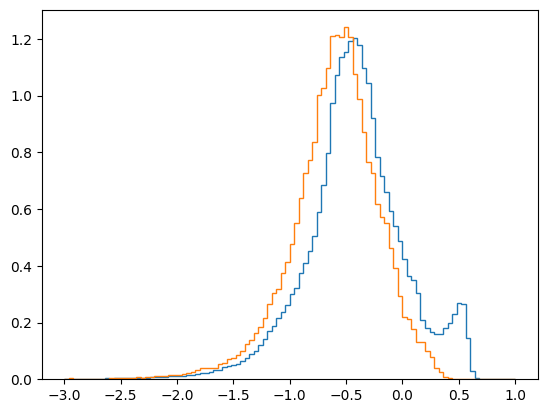

In [18]:
plt.hist(logFeH, range=(-3, 1), bins=100, histtype='step', density=True);
plt.hist(zoom_logFeH, range=(-3, 1), bins=100, histtype='step', density=True);

[Text(0.5, 0, '[Fe/H]'), Text(0, 0.5, '[alpha/Fe]')]

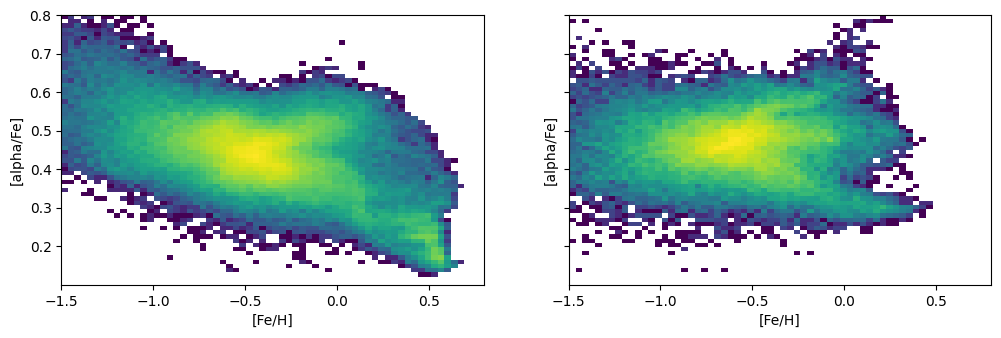

In [19]:
Nx = 64
Ny = 64

vmax = None
vmin = None

# xbins = np.linspace(-1.5, 0.2, Nx+1)
# ybins = np.linspace(0.4, 0.9, Ny+1)
xbins = np.linspace(-1.5, 0.8, Nx+1)
ybins = np.linspace(0.1, 0.8, Ny+1)

dx = (xbins[-1] - xbins[0]) / Nx
dy = (ybins[-1] - ybins[0]) / Ny

fig, axs = plt.subplots(1, 2, figsize=(12, 3.5), sharex=True, sharey=True)

mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH, logMgFe, np.ones(len(logFeH)), 
                                                         statistic='sum', bins=[xbins, ybins])
mbin /= dx * dy
# mbin = (mbin.T / np.max(mbin, axis=1)).T
im = axs[0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
                  norm = mpl.colors.LogNorm())



mbin, x_edge, y_edge, _ = binned_statistic_2d(zoom_logFeH, zoom_logMgFe, np.ones(len(zoom_logFeH)), 
                                                         statistic='sum', bins=[xbins, ybins])
mbin /= dx * dy
# mbin = (mbin.T / np.max(mbin, axis=1)).T
im = axs[1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
                  norm = mpl.colors.LogNorm())

    
axs[0].set_aspect('auto')
axs[0].set(xlabel='[Fe/H]', ylabel='[alpha/Fe]')

axs[1].set_aspect('auto')
axs[1].set(xlabel='[Fe/H]', ylabel='[alpha/Fe]')


In [69]:
fname = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/arepo/L75TNG_OutputList100.dat'
t = np.genfromtxt(fname)

In [72]:
a = t[:,0]
time = lowda.get_time(a)

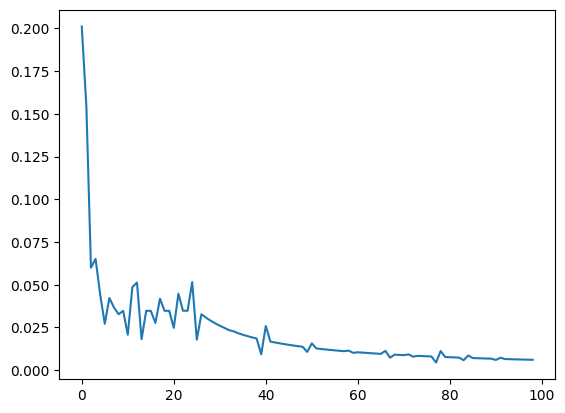

In [80]:
plt.plot(np.diff(time)/(time[1:]+time[:-1]))